$\text{}$

$$\LARGE\text{Assignment: Clustering}$$

$$\large\text{Qianlang Chen (u1172983)}$$

$$\text{CS 5140 Spring 2021}$$

$\text{}$

In [8]:
import numpy

C1 = numpy.genfromtxt('data/C1.txt')
C2 = numpy.genfromtxt('data/C2.txt')
C3 = numpy.genfromtxt('data/C3.txt')
print(C1.shape, C2.shape, C3.shape)

(20, 2) (1221, 2) (900, 5)


# Problem 1

In [13]:
def single_link(S1, S2):
    return min(numpy.linalg.norm(s1 - s2, 2) for s1 in S1 for s2 in S2)

def complete_link(S1, S2):
    return max(numpy.linalg.norm(s1 - s2, 2) for s1 in S1 for s2 in S2)

def mean_link(S1, S2):
    a1 = sum(S1) / len(S1)
    a2 = sum(S2) / len(S2)
    return numpy.linalg.norm(a1 - a2, 2)

## Part A

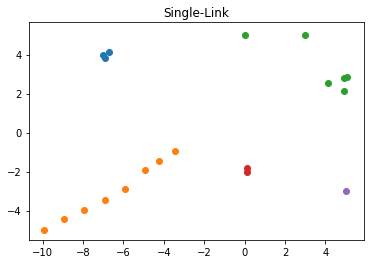

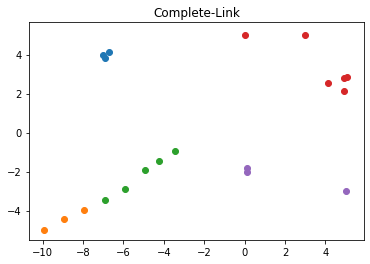

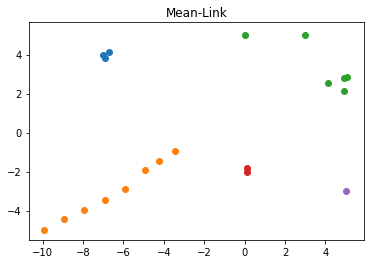

In [194]:
from matplotlib import pyplot

def hac(X, d, k):
    S = [[x] for x in X]
    while len(S) > k:
        # i and j are the indices of the closest clusters.
        i, j = min((d(S[i], S[j]), i, j)
                   for i in range(len(S) - 1)
                   for j in range(i + 1, len(S)))[1:]
        S[i].extend(S[j])
        S.pop(j)
    return S

def plot_clusters(S, title=None):
    if title: pyplot.title(title)
    for s in S: pyplot.scatter([x[0] for x in s], [x[1] for x in s])
    pyplot.show()

plot_clusters(hac(C1, single_link, 5), 'Single-Link')
plot_clusters(hac(C1, complete_link, 5), 'Complete-Link')
plot_clusters(hac(C1, mean_link, 5), 'Mean-Link')

## Part B

In this particular case, using Single-Link or Mean-Link as the distance function worked equally the best; their resulting clusters matched exactly how I'd predict looking at the plot myself. However, I believe Mean-Link is the easiest to compute because its complexity is $O(n)$ (where $n = \max(|S_1|, |S_2|)$), while it's $O(n^2)$ for both Single-Link and Complete-Link.

$\pagebreak$

# Problem 2

In [54]:
# Assuming d(x1, x2) = L2(x1 - x2) for this problem.
def d(x1, x2):
    return numpy.linalg.norm(x1 - x2, 2)

# Returns (the closest center to x, its index).
def phi_C(x, C, d):
    return min((d(x, c), c, i) for i, c in enumerate(C))[1:]

## Part A

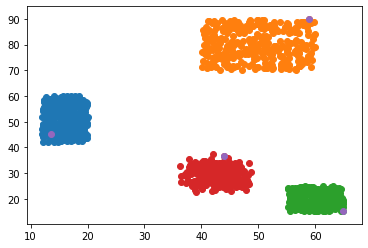

4-center-cost: 26.489508908361596
4-means-cost: 11.044765317550175


In [190]:
def gonzalez(X, d, k):
    C = [X[0]]
    for _ in range(k - 1):
        c = max((d(x, phi_C(x, C, d)[0]), x) for x in X)[1]
        C.append(c)
    S = [[] for _ in range(k)]
    for x in X: S[phi_C(x, C, d)[1]].append(x)
    return C, S

# Assuming k = |C|.
def k_center_cost(X, C, d):
    return max(d(x, phi_C(x, C, d)[0]) for x in X)

def k_means_cost(X, C, d):
    return (sum(d(x, phi_C(x, C, d)[0])**2 for x in X) / len(X))**.5

C, S = gonzalez(C2, d, 4)
plot_clusters(S + [C])
print(f'4-center-cost: {k_center_cost(C2, C, d)}')
print(f'4-means-cost: {k_means_cost(C2, C, d)}')



## Part B

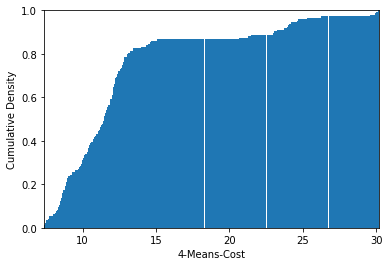

In [196]:
import random

def k_means_pp(X, d, k):
    C = [X[0]]
    for _ in range(k - 1):
        weights = [d(x, phi_C(x, C, d)[0]) for x in X]
        c = random.choices(X, weights)[0]
        C.append(c)
    S = [[] for _ in range(k)]
    for x in X: S[phi_C(x, C, d)[1]].append(x)
    return C, S

def plot_costs(costs):
    pyplot.xlabel(f'{k}-Means-Cost')
    pyplot.ylabel('Cumulative Density')
    pyplot.margins(0, 0)
    pyplot.hist(costs, 864, cumulative=True, density=True)
    pyplot.show()

costs = []
for _ in range(144):
    C = k_means_pp(C2, d, k)[0]
    costs.append(k_means_cost(C2, C, d))
plot_costs(costs)

## Part C

In [149]:
def lloyd(X, C, d, num_steps):
    for _ in range(num_steps):
        S = [[] for _ in C]
        for x in X: S[phi_C(x, C, d)[1]].append(x)
        C = [sum(s) / len(s) for s in S]
    S = [[] for _ in C]
    for x in X: S[phi_C(x, C, d)[1]].append(x)
    return C, S

#### Part C.1

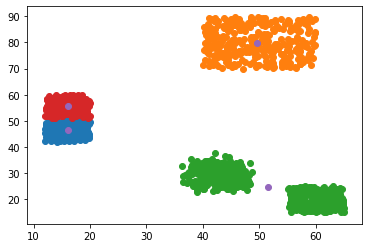

4-means-cost: 8.554318599399958


In [195]:
C_init = C2[:4]
C, S = lloyd(C2, C_init, d, 24)
plot_clusters(S + [C])
print(f'4-means-cost: {k_means_cost(C2, C, d)}')

#### Part C.2

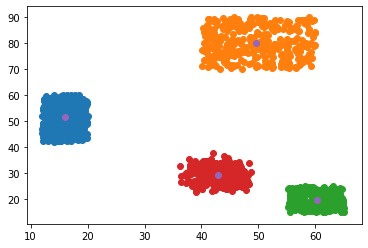

4-means-cost: 5.913781670431278


In [192]:
C_init = gonzalez(C2, d, 4)[0]
C, S = lloyd(C2, C_init, d, 24)
plot_clusters(S + [C])
print(f'4-means-cost: {k_means_cost(C2, C, d)}')

#### Part C.3

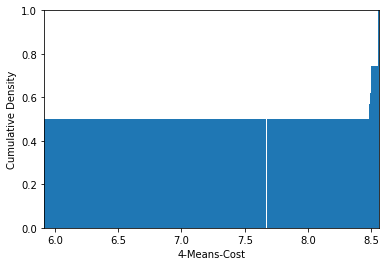

Proportion of trials where the subsets didn't change:
0.3055555555555556


In [197]:
costs = []
num_same = 0
num_trials = 144
n = len(C2)
for _ in range(num_trials):
    C_init = k_means_pp(C2, d, 4)[0]
    subset_indices_init = [phi_C(x, C_init, d)[1] for x in C2]
    C = lloyd(C2, C_init, d, 24)[0]
    subset_indices = [phi_C(x, C, d)[1] for x in C2]
    same = all((subset_indices[i] == subset_indices[j]) ==
               (subset_indices_init[i] == subset_indices_init[j])
               for i in range(n - 1) for j in range(i + 1, n))
    if same: num_same += 1
    costs.append(k_means_cost(C2, C, d))
plot_costs(costs)
print('Proportion of trials where the subsets didn\'t change:\n'
      f'{num_same / num_trials}')

$\pagebreak$

# Problem 3

In [230]:
def lloyd_medians(X, C, d, num_steps):
    for _ in range(num_steps):
        S = [[] for _ in C]
        for x in X: S[phi_C(x, C, d)[1]].append(x)
        # C = [sum(s) / len(s) for s in S]
        C = [numpy.median(s, 0) for s in S]
    S = [[] for _ in C]
    for x in X: S[phi_C(x, C, d)[1]].append(x)
    return C, S

def k_medians_cost(X, C, d):
    return sum(d(x, phi_C(x, C, d)[0]) for x in X) / len(X)

C_init = k_means_pp(C3, d, 4)[0]
C, S = lloyd_medians(C3, C_init, d, 144)
print('Centers:')
for c in C:
    print('    (' + ', '.join(map(lambda x: f'{x:.4f}', c)) + ')')
print('')
print(f'Cost: {k_medians_cost(C3, C, d)}')
numpy.savetxt('C3-centers.txt', C)


Centers:
    (1.0094, 0.0129, 0.0066, 0.0024, 0.0103)
    (-0.0118, 0.0129, -0.0166, 0.9388, 0.1013)
    (-0.0555, -0.0033, 0.9453, -0.0518, 0.0597)
    (-0.0122, 0.9578, 0.0051, 0.0139, 0.0729)

Cost: 0.6024304898274699


I used the Lloyd's algorithm, but at each step, instead of updating each center to the mean of the cluster it represents, I updated it to the median, which is a point that has the median in every dimension of the points in the cluster.